In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(1)

requests = pd.read_csv("/content/requests_every_hour.csv")

print(requests.dtypes)
requests.head()

In [ ]:
# Plotting data to visualize trends

# Daily
plt.figure(figsize=(20,5)).suptitle("Daily", fontsize=20)
plt.plot(requests.head(24))
plt.show()

# Weekly
plt.figure(figsize=(20,5)).suptitle("Weekly", fontsize=20)
plt.plot(requests.head(24*7))
plt.show()

# Totally
plt.figure(figsize=(20,5)).suptitle("Total", fontsize=20)
plt.plot(requests)
plt.show()

In [ ]:
# Preparing time series data
from sklearn.preprocessing import StandardScaler

# Scale the data
print("Data range is: ",
      [min(requests.Requests),
       max(requests.Requests)])
scaler = StandardScaler()
scaled_requests = scaler.fit_transform(requests)
print("Scaled data range is: ",
       min(scaled_requests),
       max(scaled_requests))

# 4 weeks for training
train_size = 24 * 7 * 4

# Number of lookback
lookback = 7 * 24

# Seperating train and test
train_requests = scaled_requests[0:train_size]

test_requests = scaled_requests[train_size-lookback:]

print(train_requests.shape)
print(test_requests.shape)

In [ ]:
# Prepare RNN Dataset
# Each Data point (X) is linked to lookback amount of data points
# Y is the predicted value which is after that
def create_rnn_dataset(data, lookback=1):
    data_x, data_y = [], []
    for i in range(len(data)-lookback-1):
        a = data[i:i+lookback,0]
        data_x.append(a)
        data_y.append(data[i+lookback,0])
    return np.array(data_x), np.array(data_y)

# Create rnn datasets
train_x, train_y = create_rnn_dataset(train_requests, lookback)

# reshape
train_x = np.reshape(train_x,
                     (train_x.shape[0],1,train_x.shape[1]))
print(train_x.shape,train_y.shape)

# Build and Train model

In [ ]:
# Build the LSTM Model
from keras.models import Sequential
from keras.layers import LSTM, Dense
import tensorflow as tf

tf.random.set_seed(3)

ts_model = Sequential()

ts_model.add(LSTM(256, input_shape=(1,lookback)))
ts_model.add(Dense(1))

ts_model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])
ts_model.summary()

ts_model.fit(train_x, train_y, batch_size=1, epochs=5)

# Test model

In [44]:
test_x, test_y = create_rnn_dataset(test_requests, lookback)
test_x = np.reshape(test_x,
                 (test_x.shape[0],1,test_x.shape[1]))

ts_model.evaluate(test_x, test_y, verbose=1)

# predict on training and test time series
predict_on_train = ts_model.predict(train_x)

predict_on_test = ts_model.predict(test_x)

# Inverse to visualize
predict_on_train = scaler.inverse_transform(predict_on_train)
predict_on_test = scaler.inverse_transform(predict_on_test)

print(train_x.shape)
print(test_x.shape)

(503, 1, 168)
(167, 1, 168)


# Plot the data

In [ ]:
plt.figure(figsize=(20,5)).suptitle("Prediction Model", fontsize=20)

total_size = len(predict_on_train) + len(predict_on_test)

# Target Data
orig_data = requests.Requests.to_numpy()
orig_data =orig_data.reshape(len(orig_data),1)

orig_data_plot = np.empty((total_size,1))
orig_data_plot[:,:] = np.nan
orig_data_plot[:total_size,:] = orig_data[lookback:-2,]

# Predict on training data
predict_on_train_plot = np.empty((total_size,1))
predict_on_train_plot[:,:] = np.nan
predict_on_train_plot[:len(predict_on_train),:] = predict_on_train

# Predict on Test Data
predict_on_test_plot = np.empty((total_size,1))
predict_on_test_plot[:,:] = np.nan
predict_on_test_plot[len(predict_on_train):total_size,:] = predict_on_test

plt.plot(orig_data_plot)
plt.plot(predict_on_train_plot)
plt.plot(predict_on_test_plot)
plt.show()

# Predict for next week

In [51]:
curr_input = test_x[-1,:].flatten()
print(curr_input.shape)

predict_range = 24 * 7

for i in range(predict_range):
    # choose the latest "lookback" values
    this_input = curr_input[-lookback:]
    this_input = np.reshape(this_input, (1,1,lookback))
    # predict next value
    new_value = ts_model.predict(this_input)
    # add it to the curr_input
    curr_input = np.append(curr_input, new_value)

prediction_on_future = np.reshape(np.array(curr_input[-predict_range:]),(predict_range,1))

prediction_on_future = scaler.inverse_transform(prediction_on_future)

[ 50.72602576  54.04259378  75.80710099  83.55743141 150.83297244]


# Plot Prediction

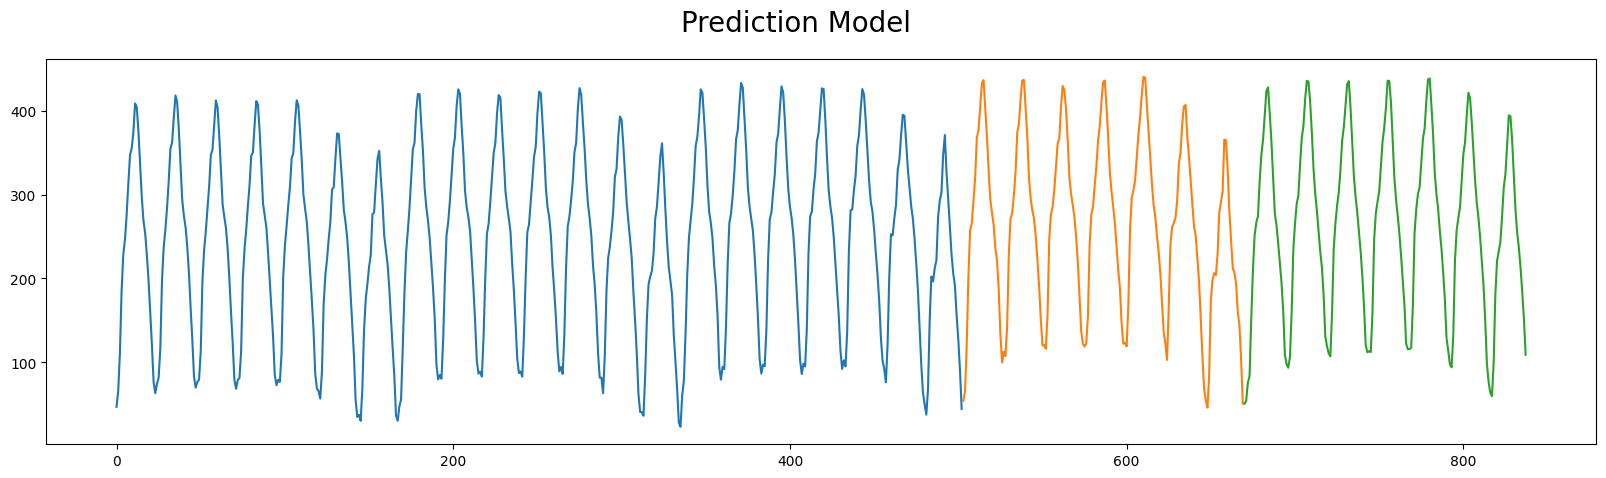

In [53]:
plt.figure(figsize=(20,5)).suptitle("Prediction Model", fontsize=20)

total_size = len(predict_on_train) + len(predict_on_test) + len(prediction_on_future)

# Predicted Past Data
predict_train_plot = np.empty((total_size,1))
predict_train_plot[:, :] = np.nan
predict_train_plot[0:len(predict_on_train), :] = predict_on_train

predict_test_plot = np.empty((total_size,1))
predict_test_plot[:, :] = np.nan
predict_test_plot[len(predict_on_train):len(predict_on_train)+len(predict_on_test), :] = predict_on_test

# Predicted Future Data
predicted_future_data = np.empty((total_size,1))
predicted_future_data[:,:] = np.nan
predicted_future_data[len(predict_on_train)+len(predict_on_test):,:] = prediction_on_future


plt.plot(predict_train_plot)
plt.plot(predict_test_plot)
plt.plot(predicted_future_data)
plt.show()